# Chapter 17: Naturally Fractured Reservoirs (Warren & Root Model)
**Author:** Ade Anggi Naluriawan Santoso

**Objective:**
In this notebook, we will calculate the unique properties of a Dual-Porosity system and visualize the characteristic pressure response.

**The Physics:**
Fluid does not flow directly from the matrix to the well.
1.  Fluid flows from **Matrix $\to$ Fracture**.
2.  Fluid flows from **Fracture $\to$ Wellbore**.

**Key Parameters:**

### 1. Storativity Ratio ($\omega$)
Describes *where* the fluid is stored.
$$\omega = \frac{(\phi c_t)_f}{(\phi c_t)_f + (\phi c_t)_m}$$
* $\omega \approx 1$: Fluid is mostly in fractures (rare).
* $\omega < 0.1$: Fluid is mostly in the matrix (typical).
* **Effect:** Controls the separation between the early-time and late-time straight lines on a semi-log plot.

### 2. Interporosity Flow Coefficient ($\lambda$)
Describes *how fast* the matrix can feed the fractures.
$$\lambda = \alpha \frac{k_m}{k_f} r_w^2$$
* **Effect:** Controls *when* the transition occurs. High $\lambda$ means the matrix kicks in quickly.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc

# Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

def calc_warren_root_parameters(phi_m, phi_f, ct_m, ct_f, k_m, k_f, h, rw, shape_factor_alpha):
    """
    Calculates Omega and Lambda for a Dual-Porosity Reservoir.
    
    Args:
        phi_m, phi_f: Porosity of matrix and fracture (fraction).
        ct_m, ct_f: Total compressibility (1/psi).
        k_m, k_f: Permeability (md).
        h: Thickness (ft).
        rw: Wellbore radius (ft).
        shape_factor_alpha: Geometric factor for matrix blocks (1/ft^2).
    """
    
    # 1. Calculate Storativity Ratio (Omega)
    # Storage Capacity = phi * ct
    storage_f = phi_f * ct_f
    storage_m = phi_m * ct_m
    
    omega = storage_f / (storage_f + storage_m)
    
    # 2. Calculate Interporosity Flow Coefficient (Lambda)
    # Note: k_f here usually refers to the 'effective' fracture permeability of the system
    # Lambda = alpha * (k_m / k_f_effective) * rw^2
    lam = shape_factor_alpha * (k_m / k_f) * (rw**2)
    
    return omega, lam

# --- EXERCISE DATA ---
# A typical fractured carbonate
phi_matrix = 0.15
phi_fracture = 0.005 # Fractures have very little volume
ct_matrix = 10e-6
ct_fracture = 10e-6  # Assume similar fluid compressibility dominate
k_matrix = 0.1       # Tight matrix
k_fracture = 500.0   # Conductive fractures
rw_val = 0.3
alpha_val = 1.0      # Shape factor depends on block size (4/L^2)

omega, lam = calc_warren_root_parameters(phi_matrix, phi_fracture, 
                                         ct_matrix, ct_fracture, 
                                         k_matrix, k_fracture, 
                                         100, rw_val, alpha_val)

print(f"--- Warren & Root Parameters ---")
print(f"Storativity Ratio (Omega): {omega:.4f}")
print(f"Interporosity Flow (Lambda): {lam:.2e}")
print(f"Interpretation: Only {omega*100:.1f}% of fluid is in fractures, but they carry the flow.")

--- Warren & Root Parameters ---
Storativity Ratio (Omega): 0.0323
Interporosity Flow (Lambda): 1.80e-05
Interpretation: Only 3.2% of fluid is in fractures, but they carry the flow.


## 2. Visualizing the Pressure Response

The signature of a naturally fractured reservoir is seen on a **Semi-Log Pressure Plot** ($P_{wf}$ vs $\log t$). It typically exhibits "Two Parallel Lines":

1.  **Early Time Line:** Flow comes only from the expansion of fractures. Slope depends on fracture permeability.
2.  **Transition (The Dip):** The pressure drops enough that the matrix starts "leaking" into the fractures, providing pressure support. The pressure drop curve flattens out.
3.  **Late Time Line:** The matrix and fractures behave as one total system. The slope is identical to the early time slope, but shifted.

We will simulate this response using the analytical solution:
$$P_D(t_D) = \frac{1}{2} \left[ \ln(t_D) + 0.80907 + E_1 \left( \frac{\lambda t_D}{\omega (1-\omega)} \right) - E_1 \left( \frac{\lambda t_D}{(1-\omega)} \right) \right]$$
*(Approximate form for infinite acting radial flow)*

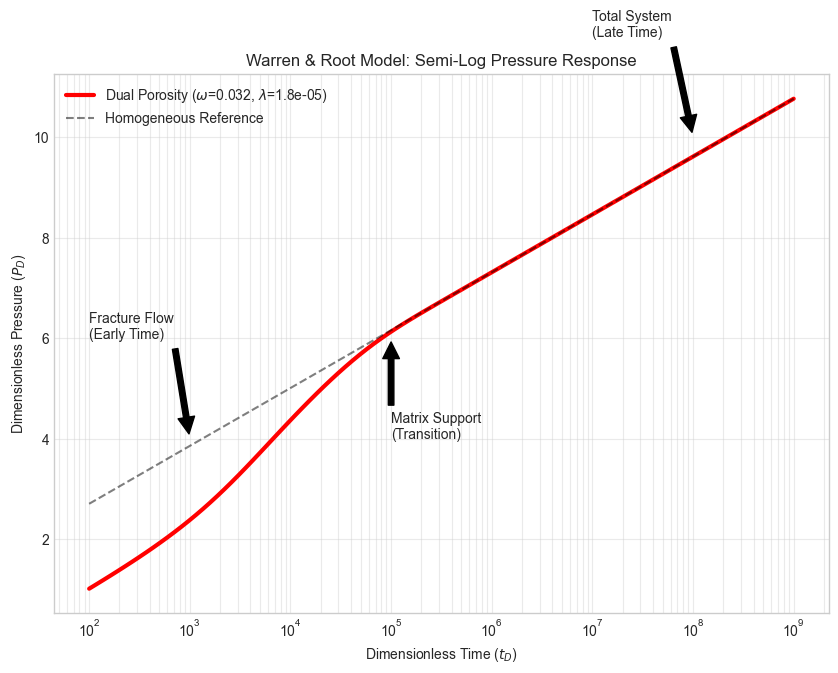

In [2]:
def calc_pressure_dual_porosity(tD_array, omega, lam):
    """
    Calculates Dimensionless Pressure (PD) for Dual Porosity system.
    Uses exponential integral E1 (scipy.special.exp1).
    """
    # Term 1: The standard radial flow solution
    # ln(tD) + 0.80907 (which is ln(1.781) approx constant for conversion)
    # Usually standard solution is 0.5 * (ln(tD) + 0.809)
    
    term_standard = np.log(tD_array) + 0.80907
    
    # Term 2: The Dual Porosity Correction (The "Dip")
    # f(t) = E1( lambda * tD / (omega * (1-omega)) ) - E1( lambda * tD / (1-omega) )
    
    arg1 = (lam * tD_array) / (omega * (1 - omega))
    arg2 = (lam * tD_array) / (1 - omega)
    
    # sc.exp1 is E1(x)
    term_correction = sc.exp1(arg1) - sc.exp1(arg2)
    
    PD = 0.5 * (term_standard + term_correction)
    return PD

# --- SIMULATE ---
# Dimensionless Time range
tD = np.logspace(2, 9, 100)

# Calculate Pressure
PD_values = calc_pressure_dual_porosity(tD, omega, lam)

# Calculate Homogeneous Reference (Omega=1, no matrix interaction)
# Just the log line
PD_homogeneous = 0.5 * (np.log(tD) + 0.80907)

# --- PLOTTING ---
plt.figure(figsize=(10, 7))

# 1. Plot Dual Porosity Response
plt.semilogx(tD, PD_values, 'r-', linewidth=3, label=f'Dual Porosity ($\omega$={omega:.3f}, $\lambda$={lam:.1e})')

# 2. Plot Homogeneous Reference
plt.semilogx(tD, PD_homogeneous, 'k--', alpha=0.5, label='Homogeneous Reference')

# Annotations
plt.title('Warren & Root Model: Semi-Log Pressure Response')
plt.xlabel('Dimensionless Time ($t_D$)')
plt.ylabel('Dimensionless Pressure ($P_D$)')

# Draw Arrows to explain regions
plt.annotate('Fracture Flow\n(Early Time)', xy=(1e3, 4), xytext=(1e2, 6),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate('Matrix Support\n(Transition)', xy=(1e5, 6), xytext=(1e5, 4),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate('Total System\n(Late Time)', xy=(1e8, 10), xytext=(1e7, 12),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.4)


plt.show()

## Conclusion

1.  **The "S" Shape:** The characteristic S-shaped transition (or flattening) in the red curve is the fingerprint of a fractured reservoir.
2.  **Omega:** Determines the vertical separation between the early and late straight lines. Smaller $\omega$ = Larger separation.
3.  **Lambda:** Determines horizontal position. Larger $\lambda$ (better connection) = Transition happens earlier (shift left).

**Interpretation:** If you test a well and see this parallel shift in the semi-log plot, you likely have natural fractures contributing to flow.